# CSGO Match Prediction with Neural Networks

In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import PolynomialFeatures

import gc
%matplotlib inline

In [4]:
# Ideas to try
# ============
# - higher learning rate, higher c, with one hot encoding
# - polyfit with no one-hot
# - polyfit with one hot
# - psuedo one-hot encoding vs summing winner data

## Loading Data

In [5]:
df = pd.read_csv('./economy.csv', low_memory=False)

In [6]:
winners = df.T.apply(pd.Series.last_valid_index)

In [7]:
winners_col = []
winnerarr = np.array(winners)
for i in range(df.shape[0]):
    winners_col.append(df[winnerarr[i]][i])
    #winners_col.append(df["team_" + str(int(df[winnerarr[i]][i]))][i])

In [8]:
df['match_winner'] = winners_col

In [9]:
round_win_col_names = [
 '16_winner',
 '17_winner',
 '18_winner',
 '19_winner',
 '20_winner',
 '21_winner',
 '22_winner',
 '23_winner',
 '24_winner',
 '25_winner',
 '26_winner',
 '27_winner',
 '28_winner',
 '29_winner',
 '30_winner']

df = df.drop(columns=round_win_col_names)
df = df.drop(columns=["best_of", "date", "t2_start"])
df = df.drop(columns=["match_id", "event_id"])

droprounds = ['16_t1', '17_t1', '18_t1', '19_t1', '20_t1', '21_t1', '22_t1', '23_t1', '24_t1', '25_t1', '26_t1', '27_t1', '28_t1', '29_t1', '30_t1', '16_t2', '17_t2', '18_t2', '19_t2', '20_t2', '21_t2', '22_t2', '23_t2', '24_t2', '25_t2', '26_t2', '27_t2', '28_t2', '29_t2', '30_t2']
df = df.drop(columns=droprounds)

In [10]:
colnames = list(df.columns)

In [11]:
#print(colnames)
xnames = colnames[:len(colnames) - 1]
#print(xnames)
X = df[xnames]

set_of_teams = set(list(X['team_1']) + list(X['team_2']))
team_to_num = dict(zip(set_of_teams, range(len(set_of_teams))))

#Replace team's name with their number
X['team_1'] = X['team_1'].replace(team_to_num)
X['team_2'] = X['team_2'].replace(team_to_num)
y = df["match_winner"]

#Convert from t1_start to t1_t and convert from t,ct to binary
X['t1_t'] = X['t1_start'].apply(lambda x: 1 if x == 't' else 0)
X = X.drop('t1_start', axis=1)

#Replace map names with numbers
map_to_num = dict(zip(X['_map'].unique(), range(len(X['_map'].unique()))))
X['_map'] = X['_map'].replace(map_to_num)

X

/var/folders/34/wwdjpw3x60scvghx_lqvyv440000gp/T/ipykernel_122/2170638273.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['team_1'] = X['team_1'].replace(team_to_num)
/var/folders/34/wwdjpw3x60scvghx_lqvyv440000gp/T/ipykernel_122/2170638273.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['team_2'] = X['team_2'].replace(team_to_num)


,team_1,team_2,_map,1_t1,2_t1,3_t1,4_t1,5_t1,6_t1,7_t1,...,7_winner,8_winner,9_winner,10_winner,11_winner,12_winner,13_winner,14_winner,15_winner,t1_t
0,263,1480,0,4350.0,1100.0,22100.0,9350.0,25750.0,10400.0,24600.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1
1,263,1480,1,3900.0,7400.0,23250.0,28500.0,31900.0,31700.0,18950.0,...,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0
2,263,1480,2,4150.0,14300.0,2000.0,24800.0,9000.0,23150.0,21850.0,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1
3,1480,2784,1,4150.0,18050.0,21000.0,25850.0,25000.0,25000.0,27250.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,1480,2784,0,4200.0,10000.0,22000.0,24500.0,27550.0,29350.0,31950.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43229,2048,726,9,4250.0,7400.0,17200.0,18500.0,26750.0,27450.0,26950.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1
43230,2784,1117,4,4250.0,1600.0,24250.0,17400.0,22050.0,6600.0,25650.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1
43231,2195,96,2,4350.0,7650.0,20000.0,21500.0,29150.0,26900.0,8750.0,...,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,0
43232,2350,1076,2,4150.0,11800.0,1200.0,22950.0,25750.0,26850.0,27850.0,...,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [12]:
y

0        2.0
1        2.0
2        2.0
3        1.0
4        1.0
        ... 
43229    2.0
43230    1.0
43231    1.0
43232    1.0
43233    1.0
Name: match_winner, Length: 43234, dtype: float64

Split and normalize the data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Neural Network

Now multiple neural networks will be fit to the data. A variety of network architecture and feature transformations are tried


In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(8, 8, 8), solver='adam')
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

In [ ]:
print("Training Set Results")
print(confusion_matrix(y_train,predict_train))
print(classification_report(y_train,predict_train))

In [ ]:
print("Validaton Set Results")
print(confusion_matrix(y_test,predict_test))
print(classification_report(y_test,predict_test))

Polynomial transformations from degree 2 to 5 are tried. The mean squared error is calculated for each and plotted to determine which degree transformation performs the best.

In [ ]:
rmses = []
degrees = np.arange(2, 4)
min_rmse, min_deg = 1e10, 0

for deg in degrees:

    # Train features
    print("Transforming features to polynomial degree %d" % deg)
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(X_train)

    # Logistic regression
    print("Fitting neural net")
    poly_mlp = MLPClassifier(hidden_layer_sizes=(8, 8, 8), solver='adam', max_iter=1000)    
    poly_mlp.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(X_test)
    print("Fit Deg: ", deg)
    poly_predict_test = poly_mlp.predict(x_poly_train)
    poly_predict = poly_mlp.predict(x_poly_test)
    print("Predict Deg: ", deg)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    
    print("Training Set Results")
    print(confusion_matrix(y_train, poly_predict_test))
    print(classification_report(y_train, poly_predict_test))
    
    print("Validaton Set Results")
    print(confusion_matrix(y_test,poly_predict))
    print(classification_report(y_test,poly_predict))
    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg
    
    del poly_features
    del x_poly_train
    del poly_mlp
    del x_poly_test
    del poly_predict
    gc.collect()

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('RMSE')

Now different values for the learning rate will be tried using the best polynomial transformation

In [ ]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]
degree = 2
rmses = []
for learning_rate in learning_rates:
    print("Training neural net with learning rate %f" % learning_rate)
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    x_poly_train = poly_features.fit_transform(X_train)

    # Logistic regression
    print("Fitting neural net")
    poly_mlp = MLPClassifier(hidden_layer_sizes=(8, 8, 8), activation='relu', solver='adam', max_iter=1000, learning_rate_init=learning_rate)    
    poly_mlp.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(X_test)
    poly_predict_test = poly_mlp.predict(x_poly_train)
    poly_predict = poly_mlp.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    
    print("Training Set Results")
    print(confusion_matrix(y_train, poly_predict_test))
    print(classification_report(y_train, poly_predict_test))
    
    print("Validaton Set Results")
    print(confusion_matrix(y_test,poly_predict))
    print(classification_report(y_test,poly_predict))
    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg
    
    del poly_features
    del x_poly_train
    del poly_mlp
    del x_poly_test
    del poly_predict
    gc.collect()
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(learning_rate, rmses)
ax.set_yscale('log')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('RMSE')


And different values for network layers as well

Training neural net with hidden layers  2
Fitting neural net
Training Set Results
[[15687  2025]
 [ 5038  9675]]
              precision    recall  f1-score   support

         1.0       0.76      0.89      0.82     17712
         2.0       0.83      0.66      0.73     14713

    accuracy                           0.78     32425
   macro avg       0.79      0.77      0.77     32425
weighted avg       0.79      0.78      0.78     32425

Validaton Set Results
[[4995  797]
 [1876 3141]]
              precision    recall  f1-score   support

         1.0       0.73      0.86      0.79      5792
         2.0       0.80      0.63      0.70      5017

    accuracy                           0.75     10809
   macro avg       0.76      0.74      0.75     10809
weighted avg       0.76      0.75      0.75     10809

Training neural net with hidden layers  8
Fitting neural net
Training Set Results
[[17327   385]
 [ 9847  4866]]
              precision    recall  f1-score   support

         1.0    

/Users/taaseenali/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training neural net with hidden layers  (45, 8, 8)
Fitting neural net
Training Set Results
[[17712     0]
 [14713     0]]
              precision    recall  f1-score   support

         1.0       0.55      1.00      0.71     17712
         2.0       0.00      0.00      0.00     14713

    accuracy                           0.55     32425
   macro avg       0.27      0.50      0.35     32425
weighted avg       0.30      0.55      0.39     32425

Validaton Set Results
[[5792    0]
 [5017    0]]
              precision    recall  f1-score   support

         1.0       0.54      1.00      0.70      5792
         2.0       0.00      0.00      0.00      5017

    accuracy                           0.54     10809
   macro avg       0.27      0.50      0.35     10809
weighted avg       0.29      0.54      0.37     10809

Training neural net with hidden layers  (45, 45, 8)


/Users/taaseenali/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting neural net
Training Set Results
[[17712     0]
 [14713     0]]
              precision    recall  f1-score   support

         1.0       0.55      1.00      0.71     17712
         2.0       0.00      0.00      0.00     14713

    accuracy                           0.55     32425
   macro avg       0.27      0.50      0.35     32425
weighted avg       0.30      0.55      0.39     32425

Validaton Set Results
[[5792    0]
 [5017    0]]
              precision    recall  f1-score   support

         1.0       0.54      1.00      0.70      5792
         2.0       0.00      0.00      0.00      5017

    accuracy                           0.54     10809
   macro avg       0.27      0.50      0.35     10809
weighted avg       0.29      0.54      0.37     10809



/Users/taaseenali/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: x and y must have same first dimension, but have shapes (1,) and (9,)

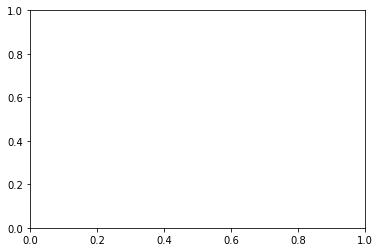

In [20]:
hidden_layers = [(2), (8), (45), (8, 8), (45, 8), (45, 45), (8, 8, 8), (45, 8, 8), (45, 45, 8)]
degree = 2
learning_rate = 0.1
rmses = []
min_rmse, min_deg = 1e10, 0


for hidden_layer in hidden_layers:
    print("Training neural net with hidden layers ", hidden_layer)
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    x_poly_train = poly_features.fit_transform(X_train)

    # Logistic regression
    print("Fitting neural net")
    poly_mlp = MLPClassifier(hidden_layer_sizes=hidden_layer, activation='relu', solver='adam', max_iter=1000, learning_rate_init=learning_rate)    
    poly_mlp.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(X_test)
    poly_predict_test = poly_mlp.predict(x_poly_train)
    poly_predict = poly_mlp.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    
    print("Training Set Results")
    print(confusion_matrix(y_train, poly_predict_test))
    print(classification_report(y_train, poly_predict_test))
    
    print("Validaton Set Results")
    print(confusion_matrix(y_test,poly_predict))
    print(classification_report(y_test,poly_predict))
    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
    
    del poly_features
    del x_poly_train
    del poly_mlp
    del x_poly_test
    del poly_predict
    gc.collect()
    
